In [78]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from yome import Session
from yome.models import *
from yome.util import to_df, report, scale_color
import re
from sqlalchemy import exists, distinct
from sqlalchemy.orm import aliased
from yome.constants import (
    colors_by_number as colors,
    hatches_by_number as hatches,
)

%mpl_setup

sns.set_style('ticks')

session = Session()

Populating the interactive namespace from numpy and matplotlib


# Load IterativeWCGNA modules

In [11]:
df = pd.read_table('../data/wgcna-membership-minmod10-2018-11-21.tsv', sep='\t').rename(columns={'Gene': 'locus_tag'})

In [12]:
df.head()

,locus_tag,Module,kME
0,b0002,UNCLASSIFIED,NaN
1,b0003,UNCLASSIFIED,NaN
2,b0004,UNCLASSIFIED,NaN
3,b0005,UNCLASSIFIED,NaN
4,b0006,UNCLASSIFIED,NaN


# Load expression data

In [13]:
tpm_log = pd.read_table('../data/precise/tpm-log.tsv', sep='\t', index_col='locus_tag')

# TODOs
- get gene names & ecocyc descriptions for all genes in each module
- plot correlation for a couple examples to confirm groups
- try clustering on log expression
- read interativeWGCNA & WGCNA papers
  + https://horvath.genetics.ucla.edu/html/CoexpressionNetwork/Rpackages/WGCNA/faq.html

# get gene names & descriptions

In [14]:
# List EcoCyc feature types
(session.query(distinct(KnowledgebaseFeature.feature_type))
 .join(KnowledgebaseGene)
 .join(Knowledgebase)
 .filter(Knowledgebase.name == 'EcoCyc')).all()

[('summary_html'),
 ('product_type'),
 ('is_pseudogene'),
 ('is_phantom_gene'),
 ('is_insertion_element'),
 ('description'),
 ('evidence_html'),
 ('component_html'),
 ('ec_number'),
 ('reaction_equation')]

In [15]:
# EcoCyc descriptions
ec = to_df((
    session.query(Gene.locus_id, 
                  KnowledgebaseGene.primary_name,
                  KnowledgebaseFeature.feature)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .join(KnowledgebaseFeature)
    .filter(Knowledgebase.name == 'EcoCyc')
    .filter(KnowledgebaseFeature.feature_type == 'description')
).all(), ['locus_tag', 'primary_name', 'description'])

In [16]:
ec.head()

,locus_tag,primary_name,description
0,b4584,rpnD,truncated recombination-promoting nuclease-lik...
1,b3328,gspG,Type II secretion system protein GspG
2,b1001,yccE,uncharacterized protein YccE
3,b2467,nudK,GDP-mannose hydrolase
4,b3549,tag,"3-methyl-adenine DNA glycosylase I, constitutive"


# Get y-ome annotations

In [22]:
yome_genes = to_df(
    session.query(Gene.locus_id,
                  KnowledgebaseGene.annotation_quality)
    .join(KnowledgebaseGene)
    .join(Knowledgebase)
    .filter(Knowledgebase.name == 'y-ome')
).rename(columns={'locus_id': 'locus_tag'})

# Join to clusters

In [23]:
clusters = df.merge(ec).merge(yome_genes)

In [24]:
g_clusters = clusters.groupby('Module')

In [25]:
# cluster size
# g_clusters['locus_tag'].agg(len).sort_values(ascending=False)

In [26]:
for name, group in g_clusters:
    print(name, len(group))
    display(group.sort_values('kME', ascending=False).head())
    break

P1_I6_M1 159


,locus_tag,Module,kME,primary_name,description,annotation_quality
1817,b2131,P1_I6_M1,0.97,osmF,glycine betaine ABC transporter periplasmic bi...,high
1972,b2302,P1_I6_M1,0.97,yfcG,disulfide reductase,high
2010,b2347,P1_I6_M1,0.97,yfdC,inner membrane protein YfdC,low
674,b0808,P1_I6_M1,0.97,ybiO,moderate conductance mechanosensitive channel,high
485,b0581,P1_I6_M1,0.96,ybdK,carboxylate-amine ligase,high


# Get number of genes by annotation quality in each group

In [109]:
clusters.annotation_quality.value_counts().get('high')

2557

In [143]:
def high(x): 
    return x.value_counts().get('high')
def low(x):
    return x.value_counts().get('low')
def excluded(x):
    return x.value_counts().get('excluded')
quality_counts = pd.DataFrame(g_clusters.annotation_quality.agg([high, low, excluded])).fillna(0)
quality_counts['size'] = quality_counts.sum(axis=1)
quality_counts.sort_values('size', ascending=False, inplace=True)
quality_counts = quality_counts.astype(int)

# rename clusters
quality_counts['new_cluster_names'] = ['unclassified'] + [f'M{x + 1}' for x in range(len(quality_counts) - 1)]
module_renaming = {v: k for k, v in dict(quality_counts['new_cluster_names']).items()}
quality_counts = quality_counts.reset_index().set_index('new_cluster_names').drop('Module', axis=1)
quality_counts.index.name = 'Module'
quality_counts.head() 

,high,low,excluded,size
Module,,,,
unclassified,1686,891,41,2618
M1,97,62,0,159
M2,46,31,0,77
M3,49,22,2,73
M4,42,12,0,54


In [134]:
print('Total genes in a cluster by type:')
by_type = quality_counts.drop('size', axis=1)
by_type.index.name = 'cluster'
by_type.reset_index(inplace=True)
by_type['in_cluster'] = by_type.cluster != 'unclassified'
by_type.groupby('in_cluster').agg(np.sum)

Total genes in a cluster by type:


,high,low,excluded
in_cluster,,,
False,1686,891,41
True,871,333,3


In [127]:
levels = {
    None: -1,
    'excluded': 0,
    'tbd': 1,
    'low': 2,
    'high': 3,
}
names = {'high': 'Well-annotated', 'low': 'y-ome', 'excluded': 'Pseudogene or phantom gene'}

In [154]:
to_plot.head()

,high,low,excluded
cluster,,,
M1,97,62,0
M2,46,31,0
M3,49,22,2
M4,42,12,0
M5,39,5,0


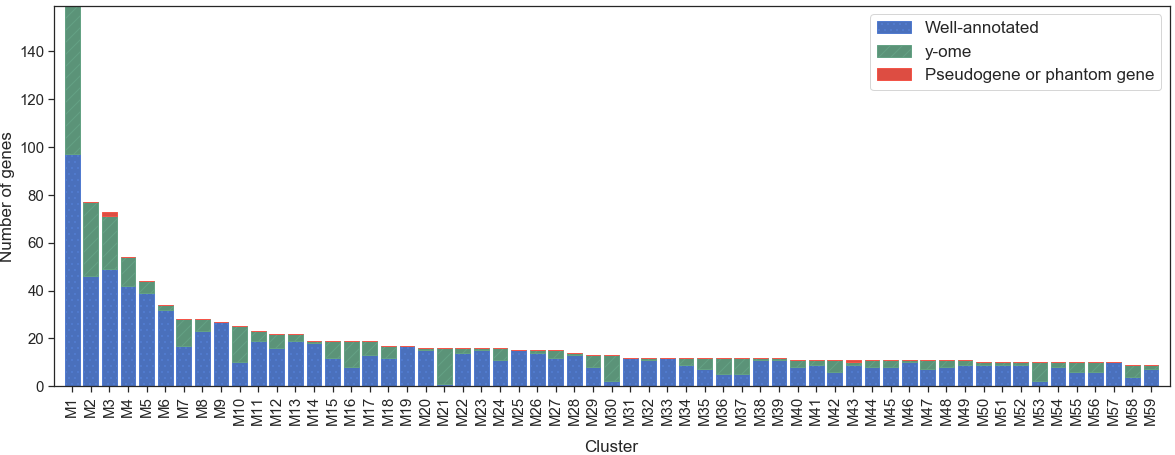

In [157]:
fig, ax = plt.subplots(figsize=(20, 7))
to_plot = quality_counts.drop('unclassified').drop('size', axis=1)
last = [0] * len(to_plot)
for label, column in to_plot.T.iterrows():
    c = colors[levels[label]]
    ax.bar(range(len(column)), column, bottom=last, color=c, hatch=hatches[levels[label]], edgecolor=scale_color(c, 1.1), label=names[label])
    last = column + last
ax.set_xticklabels(to_plot.index, rotation='vertical')
ax.set_xticks(range(len(to_plot)))
ax.set_ylabel('Number of genes')
ax.set_xlabel('Cluster', labelpad=15)
ax.set_xlim([-1, len(to_plot)])
ax.legend()
fig.set_facecolor('white')
fig.savefig('/Users/zaking/lab/y-ome/figs/clusters.pdf')
fig.savefig('/Users/zaking/lab/y-ome/figs/clusters.png')

## highest y-ome percentage

In [129]:
quality_counts_frac = quality_counts.loc[:,:]
quality_counts_frac['yome_fraction'] = quality_counts_frac.low / quality_counts_frac['size']

In [130]:
quality_counts_frac.sort_values('yome_fraction', ascending=True).head(20)

,high,low,excluded,size,yome_fraction
cluster,,,,,
M57,10,0,0,10,0.000000
M25,15,0,0,15,0.000000
M31,12,0,0,12,0.000000
M19,17,0,0,17,0.000000
M33,12,0,0,12,0.000000
M9,27,0,0,27,0.000000
M14,18,1,0,19,0.052632
M6,32,2,0,34,0.058824
M23,15,1,0,16,0.062500


In [131]:
quality_counts_frac.sort_values('yome_fraction', ascending=False).head()

,high,low,excluded,size,yome_fraction
cluster,,,,,
M21,1,15,0,16,0.937500
M30,2,11,0,13,0.846154
M53,2,8,0,10,0.800000
M10,10,15,0,25,0.600000
M36,5,7,0,12,0.583333


In [158]:
g_clusters.get_group(module_renaming['M21'])

,locus_tag,Module,kME,primary_name,description,annotation_quality
273,b0329,P2_I5_M11,0.91,yahO,DUF1471 domain-containing protein YahO,low
368,b0435,P2_I5_M11,0.90,bolA,DNA-binding transcriptional dual regulator BolA,high
862,b1003,P2_I5_M11,0.86,yccJ,PF13993 family protein YccJ,low
1004,b1177,P2_I5_M11,0.83,ycgJ,PF05666 family protein YcgJ,low
1022,b1195,P2_I5_M11,0.90,ymgE,PF04226 family protein YmgE,low
1459,b1724,P2_I5_M11,0.96,ydiZ,protein YdiZ,low
1527,b1795,P2_I5_M11,0.89,yeaQ,PF04226 family protein YeaQ,low
1542,b1810,P2_I5_M11,0.85,yoaC,DUF1889 domain-containing protein YoaC,low
1568,b1836,P2_I5_M11,0.89,yebV,protein YebV,low
1674,b1953,P2_I5_M11,0.88,yodD,stress-induced protein,low


# Check in expression set

In [132]:
exp = pd.read_table('../data/precise/tpm-log.tsv', sep='\t', index_col='locus_tag')

In [101]:
top2 = exp[exp.index.isin(['b4269', 'b2131'])].iloc[:, 1:].T

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


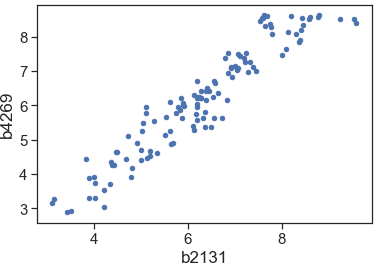

In [103]:
top2.plot(x='b2131', y='b4269', kind='scatter')

In [104]:
top2.corr()

locus_tag,b2131,b4269
locus_tag,,
b2131,1.00000,0.94962
b4269,0.94962,1.00000
